# BigData - Exercise 1
Tom Koch 301755088
Jhonathan Gang 200877157

Dataset used: 'kickstart-projects' from kaggle
https://www.kaggle.com/kemical/kickstarter-projects
* The data contained two csv files, we only loaded 'ks-projects-201801.csv'

In [1]:
#Initializing PySpark
from pyspark import SparkContext, SparkConf

# #Spark Config
conf = SparkConf().setAppName("Ex1")
sc = SparkContext(conf=conf)


In [2]:
sc


<SparkContext master=local[*] appName=Ex1>

# 1. Load your dataset.

The text column contains commas, so reading the csv as a text file and splitting with by ',' didn't load the csv as needed.
After verifying it was ok with Mark we used 'databricks' with 'sqlContext.read.format' in order to first load the csv

In [3]:
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)

df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true', quote='"',
                                                                delimiter=',', escape='"').load(
    'ks-projects-201801.csv')
print("number of rows: ", df.count())
print("number of columns: ", len(df.columns))


number of rows:  378661
number of columns:  15


In [4]:
#we will use a list and dictionary to help us maintain the columns names & indexes in the RDD
COL_NAMES = ['name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state',
             'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']
COL_NAMES_INDEXES = {k: v for v, k in enumerate(COL_NAMES)}


# 2. Transform the data set into RDD pair, where the key is the unique id and the value is a Python list which contains the rest of the columns.

In [5]:
x = df.rdd.map(lambda x: (x.ID, list(x[1:])))
x.getNumPartitions()


2

# 3. Choose 5 important columns and for each column
a. Count the distinct values in each one of them.
b. Create histogram to analyze the distribution of the above columns (normalize?).
c. Explain your results.

Number of distinct values in the country column: 23


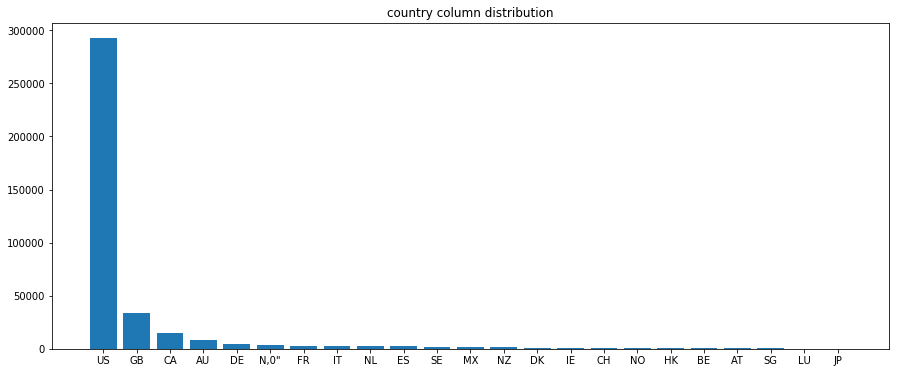

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# COUNTRY COLUMN
col_name = "country"
col_index=COL_NAMES_INDEXES[col_name]
rdd_mapped = x.map(lambda x: (x[1][col_index], 1))
rdd_reduced = rdd_mapped.reduceByKey(lambda x, y: x + y).map(lambda x: (x[1], x[0])).sortByKey(False).collect()

print("Number of distinct values in the", col_name, "column:", len(rdd_mapped.distinct().countByKey()))

fig = plt.figure(figsize=(15, 6))
amount, label = zip(*rdd_reduced)
plt.bar(label, amount)
plt.title(col_name + " column distribution")
plt.show()


In [7]:
x.filter(lambda x: x[1][col_index] == 'N,0"').count()


3797

There are 3,797 observations with the country N,0" - probably N/A. We will continue to explore this shortly.

Most of the projects are from the United States (77%)

Number of distinct values in the currency column: 14


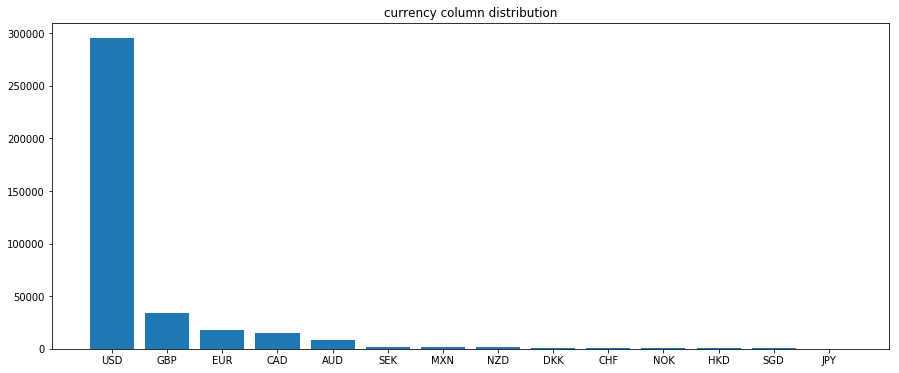

In [8]:
#CURRENCY COLUMN
col_name = 'currency'
col_index=COL_NAMES_INDEXES[col_name]
rdd_mapped = x.map(lambda x: (x[1][col_index], 1))
rdd_reduced = rdd_mapped.reduceByKey(lambda x, y: x + y).map(lambda x: (x[1], x[0])).sortByKey(False).collect()

print('Number of distinct values in the', col_name, "column:", len(rdd_mapped.distinct().countByKey()))

fig = plt.figure(figsize=(15, 6))
amount, label = zip(*rdd_reduced)
plt.bar(label, amount)
plt.title(col_name + " column distribution")
plt.show()


As expected from the country distribution, most of the project's currency is USD, with GBP and EURO in the second and third place (obviously there is a correlation between the countries and currencies used.)

Number of distinct values in the state column: 6


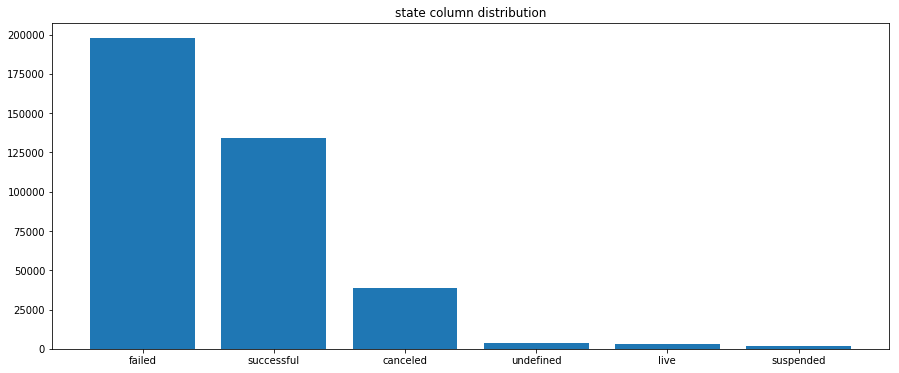

In [9]:
#STATE COLUMN
col_name = "state"
col_index=COL_NAMES_INDEXES[col_name]
rdd_mapped = x.map(lambda x: (x[1][col_index], 1))
rdd_reduced=rdd_mapped.reduceByKey(lambda x, y: x+y).map(lambda x:(x[1],x[0])).sortByKey(False).collect()

print("Number of distinct values in the", col_name, "column:", len(rdd_mapped.distinct().countByKey()))

fig = plt.figure(figsize=(15, 6))
amount, label = zip(*rdd_reduced)
plt.bar(label, amount)
plt.title(col_name+" column distribution")
plt.show()


More projects failed than succeeded. More than half have failed, 10% was canceled and only 35% successed

 The distribution of "usd_goal_real" and "usd_pledged_real" are porbably heavily right-skewed due to many projects that received little to no funding and extremely high outliers.
 We will use a log transformation on both variables to better visualize their distributions.

Number of distinct values in the usd_goal_real column: 50339


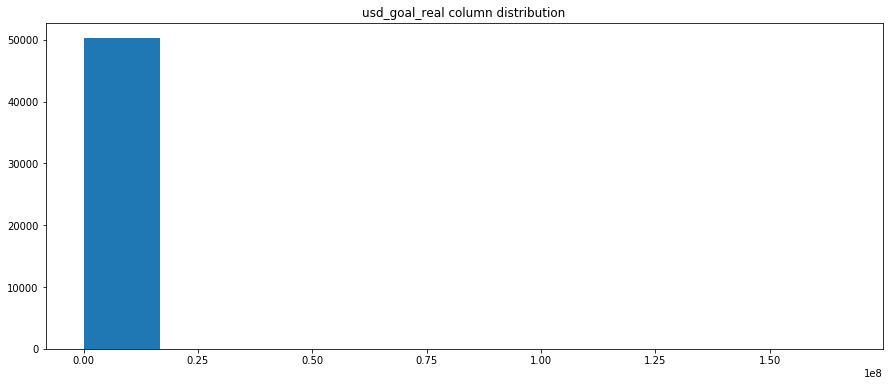

In [10]:
#USD_GOAL_REAL COLUMN
col_name = "usd_goal_real"
col_index=COL_NAMES_INDEXES[col_name]
rdd_mapped = x.map(lambda x: (x[1][col_index], 1))
rdd_reduced = rdd_mapped.reduceByKey(lambda x, y: x+y).map(lambda x: (x[1], x[0])).sortByKey(False).collect()

print("Number of distinct values in the", col_name, "column:", len(rdd_mapped.distinct().countByKey()))

fig = plt.figure(figsize=(15, 6))
amount, label = zip(*rdd_reduced)
plt.hist(label)
plt.title(col_name+" column distribution")
plt.show()


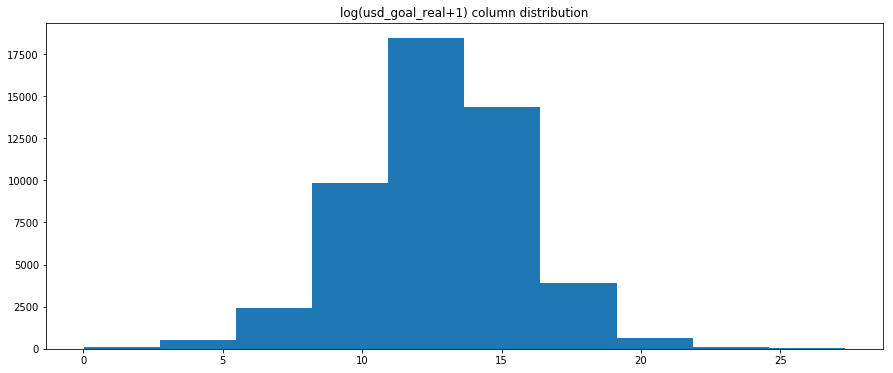

In [11]:
label_log_plus_1 = np.log2(np.add(label, 1))
fig = plt.figure(figsize=(15, 6))
plt.hist(label_log_plus_1)
plt.title("log("+col_name+"+1) column distribution")
plt.show()


Number of distinct values in the usd_pledged_real column: 106065


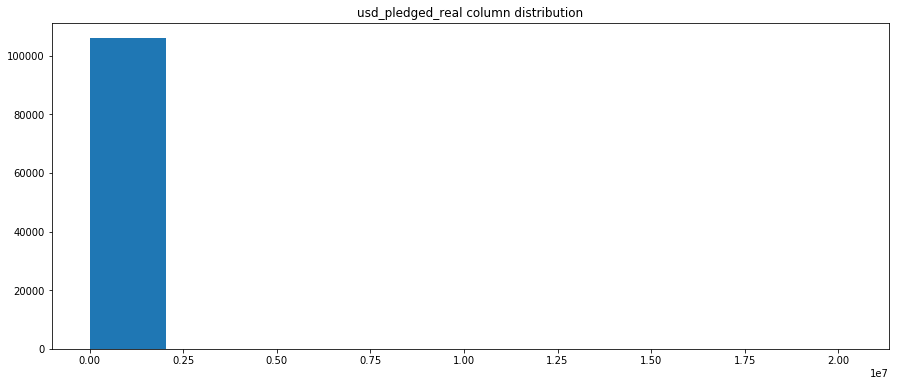

In [12]:
#USD_PLEDGED_REAL COLUMN
col_name = "usd_pledged_real"
col_index=COL_NAMES_INDEXES[col_name]
rdd_mapped = x.map(lambda x: (x[1][col_index], 1))
rdd_reduced = rdd_mapped.reduceByKey(lambda x, y: x+y).map(lambda x: (x[1], x[0])).sortByKey(False).collect()
print("Number of distinct values in the", col_name, "column:", rdd_mapped.distinct().count())

fig = plt.figure(figsize=(15, 6))
amount, label = zip(*rdd_reduced)
plt.hist(label)
plt.title(col_name + " column distribution")
plt.show()


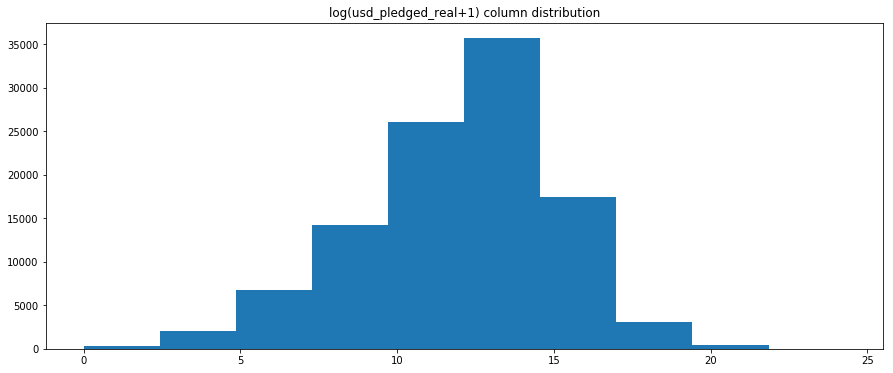

In [13]:
label_log_plus_1 = np.log2(np.add(label, 1))
fig = plt.figure(figsize=(15, 6))
plt.hist(label_log_plus_1)
plt.title("log("+col_name+"+1) column distribution")
plt.show()


Both distributions really are heavily right-skewed due to many projects that received little to no funding and extremely high outliers. The log ditribution shows us that goal has a normal distribution, while the pledged seems to be right-skewed

# 4. Fill in bad or missing value (zero,mean or median). Explain your solution.

In [14]:
#first we'll find the columns containing NA
for i in range(0, len(COL_NAMES)):
    rdd_mapped = x.filter(lambda x: x[1][i] == None)
    print(COL_NAMES[i], "Number of NA:", rdd_mapped.count())


name Number of NA: 4
category Number of NA: 0
main_category Number of NA: 0
currency Number of NA: 0
deadline Number of NA: 0
goal Number of NA: 0
launched Number of NA: 0
pledged Number of NA: 0
state Number of NA: 0
backers Number of NA: 0
country Number of NA: 0
usd pledged Number of NA: 3797
usd_pledged_real Number of NA: 0
usd_goal_real Number of NA: 0


There are only two columns containing NA: 
* name - which contains only 4 NA, so we'll just drop those observations
* usd pledged - contains 3797 NA, which is about 1% of the entire dataset. These probably correspands to the NA (N,0") in the 'country' column.

Filling the NA in 'usd pledged" with 0/mean/median is wrong because we can't make such a general assumption on all of these projects (can we say all of these column will receive 0 pledges? The mean pledge?)
Because it is only 1% of our dataset, We'll just drop these values.
Other options: 
* Importing data about convertion rates in previous years and calculating the usd_pledged according to the 'pledge' and 'currency' columns
* Ignoring those NA, as we have this information stored in 'usd_pledged_real' column

In [15]:
#first let's check if the observations with weird country 'N,0' really correspands to the ones in 'usd pledged' column
country_col_index=COL_NAMES_INDEXES['country']
usd_pledged_col_index=COL_NAMES_INDEXES['usd pledged']
x.filter(lambda a: a[1][usd_pledged_col_index] == None).map(lambda b: (b[1][country_col_index], b[1][usd_pledged_col_index])).take(20)


[('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None),
 ('N,0"', None)]

It appears that the country 'N,0"' is connected to the NA found in usd pledged

In [6]:
#Dropping NA from the 'name' column
col_index=COL_NAMES_INDEXES['name']
print("Size before: " + str(x.count()))
x = x.filter(lambda x: x[1][col_index] != None)
print("Size after removing NA from name: " + str(x.count()))

#Dropping NA from the 'usd pledged' column
col_index=COL_NAMES_INDEXES['usd pledged']
x = x.filter(lambda x: x[1][col_index] != None)
print("Size after removing NA from usd pledged: " + str(x.count()))


Size before: 378661
Size after removing NA from name: 378657
Size after removing NA from usd pledged: 374864


In [ ]:
#If there was a justification for filling those NA with the column's mean, we could have done so like this:

#calculating the column's mean
# col_index=COL_NAMES_INDEXES['usd pledged']
# usd_pledged_mean = x.filter(lambda x: x[1][col_index] != None).map(lambda x: x[1][col_index]).mean()
#filling the NA with the mean we just found:
# x=x.map(lambda x: (x[0],
#                    x[1][:col_index]
#                    + [usd_pledged_mean if x[1][col_index] == None else x[1][col_index]]
#                    + x[1][col_index+1:]))


# 5. Transform 2 columns which contains categorical features to numerical values. Explain your method.

As we saw when we looked at the distribution of the 'currency' column, about 80% of all projects use USD, and about 10% use GBP. We'll transform the 'currency' column into the next 3 binary columns:
a. 'is_usd' which will contain 1 if the currency is USD and 0 otherwise
b. 'is_gbp' which will contain 1 if the currency is GBP and 0 otherwise
c. 'is_other_currency' which will accept 1  if the currency is neither USD or GBP, and 0 otherwise

In [18]:
col_index=COL_NAMES_INDEXES['currency']
rdd_usd = x.map(lambda x: (x[0], x[1][col_index] == 'USD'))
x = x.join(rdd_usd)
x = x.map(lambda x: (x[0], [*x[1][0], x[1][1]]))
#adding the new value to COL_NAMES and COL_NAMES_INDEXES for easier maintance
COL_NAMES.append('is_usd')
COL_NAMES_INDEXES['is_usd']=len(COL_NAMES)-1


In [19]:
rdd_gbp = x.map(lambda x: (x[0], x[1][col_index] == 'GBP'))
x = x.join(rdd_gbp)
x = x.map(lambda x: (x[0], [*x[1][0], x[1][1]]))
#adding the new value to COL_NAMES and COL_NAMES_INDEXES for easier maintance
COL_NAMES.append('is_gbp')
COL_NAMES_INDEXES['is_gbp']=len(COL_NAMES)-1


In [20]:
rdd_other_currency = x.map(lambda x: (x[0], x[1][col_index] not in ['USD', 'GBP']))
x = x.join(rdd_other_currency)
x = x.map(lambda x: (x[0], [*x[1][0], x[1][1]]))
#adding the new value to COL_NAMES and COL_NAMES_INDEXES for easier maintance
COL_NAMES.append('is_other_currency')
COL_NAMES_INDEXES['is_other_currency']=len(COL_NAMES)-1


In [21]:
#let's take a look at how a single Row looks in our RDD at the moment
x.first()


(1000055792,
 ['The Cottage Market',
  'Crafts',
  'Crafts',
  'USD',
  datetime.datetime(2014, 10, 2, 0, 0),
  5000.0,
  datetime.datetime(2014, 9, 2, 17, 11, 50),
  0.0,
  'failed',
  0,
  'US',
  0.0,
  0.0,
  5000.0,
  True,
  False,
  False])

From the state column we can assess whether the project successed or failed.
We'll transform the 'state' column into the next 3 binary columns:
a. 'is_successfull' which will contain 1 if the state of the project is 'successful'
b. 'is_failed' which will contain 1 if the state of the project is 'failed' OR 'canceled'
c. 'is_other_state' which will accept 1 if the state of the project is 'live' or 'suspended'

In [22]:
col_index=COL_NAMES_INDEXES['state']
rdd_successful = x.map(lambda x: (x[0], x[1][col_index] == 'successful'))
x = x.join(rdd_successful)
x = x.map(lambda x: (x[0], [*x[1][0], x[1][1]]))
#adding the new value to COL_NAMES and COL_NAMES_INDEXES for easier maintance
COL_NAMES.append('is_successful')
COL_NAMES_INDEXES['is_successful']=len(COL_NAMES)-1


In [23]:
rdd_failed = x.map(lambda x: (x[0], x[1][col_index] in ['failed', 'canceled']))
x = x.join(rdd_failed)
x = x.map(lambda x: (x[0], [*x[1][0], x[1][1]]))
#adding the new value to COL_NAMES and COL_NAMES_INDEXES for easier maintance
COL_NAMES.append('is_fail')
COL_NAMES_INDEXES['is_fail']=len(COL_NAMES)-1


In [24]:
rdd_other_state = x.map(lambda x: (x[0], x[1][col_index] in ['live', 'suspended', 'undefined']))
x = x.join(rdd_other_state)
x = x.map(lambda x: (x[0], [*x[1][0], x[1][1]]))
#adding the new value to COL_NAMES and COL_NAMES_INDEXES for easier maintance
COL_NAMES.append('is_other_state')
COL_NAMES_INDEXES['is_other_state']=len(COL_NAMES)-1


In [25]:
#let's take a look at how a single Row looks in our RDD at the moment
x.first()


(1000068480,
 ['Notes From London: Above & Below',
  'Art Books',
  'Publishing',
  'USD',
  datetime.datetime(2015, 5, 10, 0, 0),
  3000.0,
  datetime.datetime(2015, 4, 10, 21, 20, 54),
  789.0,
  'failed',
  20,
  'US',
  789.0,
  789.0,
  3000.0,
  True,
  False,
  False,
  False,
  True,
  False])

# 6. Transform the timestamp into categorical features (hour, day, month)

We will transform the time stamp in 'deadline' column to the categorical features

In [26]:
from datetime import datetime
col_index=COL_NAMES_INDEXES['deadline']
hour_rdd = x.map(lambda x: (x[0], x[1][col_index].hour))
x = x.join(hour_rdd)
x = x.map(lambda x: (x[0], [*x[1][0], x[1][1]]))
#adding the new value to COL_NAMES and COL_NAMES_INDEXES for easier maintance
COL_NAMES.append('deadline_hour')
COL_NAMES_INDEXES['deadline_hour']=len(COL_NAMES)-1


In [27]:
day_rdd = x.map(lambda x: (x[0], x[1][col_index].day))
x = x.join(day_rdd)
x = x.map(lambda x: (x[0], [*x[1][0], x[1][1]]))
#adding the new value to COL_NAMES and COL_NAMES_INDEXES for easier maintance
COL_NAMES.append('deadline_day')
COL_NAMES_INDEXES['deadline_day']=len(COL_NAMES)-1


In [28]:
month_rdd = x.map(lambda x: (x[0], x[1][col_index].month))
x = x.join(month_rdd)
x = x.map(lambda x: (x[0], [*x[1][0], x[1][1]]))
#adding the new value to COL_NAMES and COL_NAMES_INDEXES for easier maintance
COL_NAMES.append('deadline_month')
COL_NAMES_INDEXES['deadline_month']=len(COL_NAMES)-1


In [29]:
#validity check
print(x.take(1)[0][1][col_index])
print("hour:", x.take(1)[0][1][COL_NAMES_INDEXES['deadline_hour']], "day:",
      x.take(1)[0][1][COL_NAMES_INDEXES['deadline_day']],
      "month:", x.take(1)[0][1][COL_NAMES_INDEXES['deadline_month']])


2017-05-15 00:00:00
hour: 0 day: 15 month: 5


# 7. Choose 2 columns and normalize them.

We will normalize the 'usd_goal_real' column and the 'usd_pledged_real' column

In [30]:
#normalizing 'usd_goal_real' column
col_index=COL_NAMES_INDEXES['usd_goal_real']
usd_goal_real_mean = x.map(lambda x: x[1][col_index]).mean()
usd_goal_real_std = x.map(lambda x: x[1][col_index]).stdev()
print("Mean is:", usd_goal_real_mean)
print("Standard deviation is:", usd_goal_real_std)


Mean is: 45454.40146545325
Standard deviation is: 1152948.5326838526


In [31]:
#adding the normalized column to our main rdd
x = x.map(lambda x: (x[0], [*x[1], (x[1][col_index] - usd_goal_real_mean) / usd_goal_real_std]))
#adding the new value to COL_NAMES and COL_NAMES_INDEXES for easier maintance
COL_NAMES.append('normalized_usd_goal_real')
COL_NAMES_INDEXES['normalized_usd_goal_real']=len(COL_NAMES)-1


In [32]:
#validity check:
col_index=COL_NAMES_INDEXES['normalized_usd_goal_real']
normalized_goal_mean = x.map(lambda x: x[1][col_index]).mean()
normalized_goal_std = x.map(lambda x: x[1][col_index]).stdev()
print("Mean is:", normalized_goal_mean)
print("Standard deviation is:", normalized_goal_std)


Mean is: 1.4785807127271067e-17
Standard deviation is: 0.9999999999999983


In [33]:
#normalizing 'usd_pledged_real' column
col_index=COL_NAMES_INDEXES['usd_pledged_real']
usd_pledged_real_mean = x.map(lambda x: x[1][col_index]).mean()
usd_pledged_real_real_std = x.map(lambda x: x[1][col_index]).stdev()
print("Mean is:", usd_pledged_real_mean)
print("Standard deviation is:", usd_pledged_real_real_std)


Mean is: 9058.924074119075
Standard deviation is: 90973.22298213448


In [34]:
#adding the normalized column to our main rdd
x = x.map(lambda x: (x[0], [*x[1], (x[1][col_index] - usd_pledged_real_mean) / usd_pledged_real_real_std]))
#adding the new value to COL_NAMES and COL_NAMES_INDEXES for easier maintance
COL_NAMES.append('normalized_usd_pledged_real')
COL_NAMES_INDEXES['normalized_usd_pledged_real']=len(COL_NAMES)-1


In [35]:
#validity check:
col_index=COL_NAMES_INDEXES['normalized_usd_pledged_real']
normalized_usd_pledged_real_mean = x.map(lambda x: x[1][col_index]).mean()
normalized_usd_pledged_real_std = x.map(lambda x: x[1][col_index]).stdev()
print("Mean is:", normalized_usd_pledged_real_mean)
print("Standard deviation is:", normalized_usd_pledged_real_std)


Mean is: -8.972958823443705e-17
Standard deviation is: 1.0000000000000007


In [36]:
#again, let's check and see how a single Row in our main RDD looks like
x.first()


(1005116416,
 ['Pursu. Passion. Career.',
  'Technology',
  'Technology',
  'USD',
  datetime.datetime(2017, 5, 15, 0, 0),
  52000.0,
  datetime.datetime(2017, 4, 20, 23, 42, 45),
  153.0,
  'failed',
  2,
  'US',
  153.0,
  153.0,
  52000.0,
  True,
  False,
  False,
  False,
  True,
  False,
  0,
  15,
  5,
  -0.039291781186450624,
  -0.09789610373448064])

# 8. Transform one of your text features.
a. Do tokenization.
b. Stop word removal - use the function StopWordsRemover from
http://spark.apache.org/docs/latest/ml-features.html#stopwordsremover
c. Binary vectorization.

We will choose the 'name' column as our text feature.
* Because StopWordsRemover only applies to dataframes, and in this assignment we are required to use rdd - We used the function to get the list of stop words (using the getStopWords() method) and removed the stop words ourselves.
* In addition to the removal of stop-words, we also made the text lower case, removed punctuation and removed short words (words consisting of 1 or 2 letters)

In [7]:
import re
from pyspark.ml.feature import StopWordsRemover

col_index=COL_NAMES_INDEXES['name']

#getting the stop words as requested
remover = StopWordsRemover()
stop_words_list = remover.getStopWords()

#tokenization by word + lowercase + punctuation removal
tokenized_text_rdd = x.map(lambda x: (x[0], re.sub(r'[^\w\s]', '', x[1][col_index]).lower().split()))
tokenized_text_rdd.first()


(1000002330, ['the', 'songs', 'of', 'adelaide', 'abullah'])

In [8]:
#stop word removal + removing words with only 2 letters or less
tokenized_text_rdd = tokenized_text_rdd.map(
    lambda x: (x[0], [w for w in x[1] if not w in stop_words_list and len(w) > 2]))
tokenized_text_rdd.take(6)


[(1000002330, ['songs', 'adelaide', 'abullah']),
 (1000003930, ['greeting', 'earth', 'zgac', 'arts', 'capsule']),
 (1000004038, ['hank']),
 (1000007540,
  ['toshicapital', 'rekordz', 'needs', 'help', 'complete', 'album']),
 (1000011046,
  ['community', 'film', 'project', 'art', 'neighborhood', 'filmmaking']),
 (1000014025, ['monarch', 'espresso', 'bar'])]

In [23]:
#Binary vectorization
#WQe'll use broadcast so the large corpus dict will be shared accross nodes
CORPUS_WORDS = sc.broadcast(list(set(tokenized_text_rdd.flatMap(lambda x: x[1]).collect()))) 
print("number of words in corpus:", len(CORPUS_WORDS.value))
CORPUS_WORDS_DICT = sc.broadcast({k: v for v, k in enumerate(CORPUS_WORDS.value)})



number of words in corpus: 169107


In [45]:
#helper function that calculates the binary vectorization of the observation's text according to the corpus vocabulary
def binary_vect_func(rdd_item):
    project_name_words = rdd_item[1]
    res=np.zeros(len(CORPUS_WORDS.value))
    for w in project_name_words:
        res[CORPUS_WORDS_DICT.value[w]]=1
        
    return (rdd_item[0], res.tolist())



In [46]:
binary_vect_rdd=tokenized_text_rdd.map(binary_vect_func)
binary_vect_rdd.take(1)


[(1000002330,
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
  

In [47]:
#adding the tokenized name (without stopwords) to the main rdd
x = x.join(tokenized_text_rdd)
x = x.map(lambda x: (x[0], [*x[1][0], x[1][1]]))
#adding the new value to COL_NAMES and COL_NAMES_INDEXES for easier maintance
COL_NAMES.append('tokenized_text_rdd')
COL_NAMES_INDEXES['tokenized_text_rdd']=len(COL_NAMES)-1


In [48]:
#adding the binary vectoraziation to the main rdd
x = x.join(binary_vect_rdd)
x = x.map(lambda x: (x[0], [*x[1][0], x[1][1]]))
#adding the new value to COL_NAMES and COL_NAMES_INDEXES for easier maintance
COL_NAMES.append('binary_vect_rdd')
COL_NAMES_INDEXES['binary_vect_rdd']=len(COL_NAMES)-1
